# **Library Imports**.


In [2]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt


In [3]:
# Ensure pyarrow is installed in this kernel
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.2 MB/s eta 0:00:00


# **Data Loading and Initial Image Preprocessing**


In [5]:
# Load parquet files
# Make sure to reference download instructions. You have to download the kaggle dataset and upload it, rename it to a data directory. Video guide coming soon
#from: https://drive.google.com/drive/folders/12-1XR8df-rYkwJuMqMgXYQ9dm6EoDx0f?usp=drive_link
#quickstart guide: https://www.youtube.com/watch?v=WPRarAeelAM
#Original source + description: https://advp.niagads.org/downloads
train_df = pd.read_parquet("/content/drive/MyDrive/AI Journey/AI 4 Alzheimer's/Datasets/MRI Dataset/train.parquet")
test_df  = pd.read_parquet("/content/drive/MyDrive/AI Journey/AI 4 Alzheimer's/Datasets/MRI Dataset/test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))




1. label = 2


/tmp/ipython-input-4051836937.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


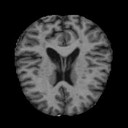

2. label = 0


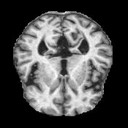

3. label = 3


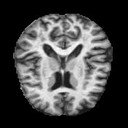

4. label = 3


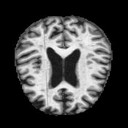

5. label = 2


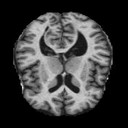

6. label = 2


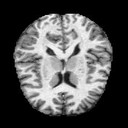

7. label = 2


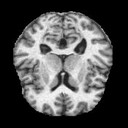

8. label = 2


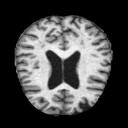

9. label = 3


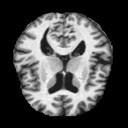

10. label = 2


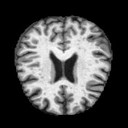

In [6]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(train_df)

# **Image Preprocessing for ResNet50 and Data Generators**

In [8]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def preprocess_image_resnet(image):
    # Resize the image to the target size for ResNet50
    image = Image.fromarray(image.astype('uint8'), mode='L').convert('RGB') # ResNet50 expects 3 channels
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image).astype('float32')
    # Rescale pixel values to [-1, 1] as expected by ResNet50
    image = (image / 127.5) - 1.0
    return image

# Apply preprocessing to the DataFrames
train_df["processed_image"] = train_df["image"].apply(preprocess_image_resnet)
test_df["processed_image"] = test_df["image"].apply(preprocess_image_resnet)

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indices]

        X = np.array([img for img in batch_df["processed_image"]])
        y = np.array(batch_df["label"])

        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)


train_generator = CustomDataGenerator(train_df, BATCH_SIZE)
test_generator = CustomDataGenerator(test_df, BATCH_SIZE, shuffle=False)

print("Data generators created successfully.")

/tmp/ipython-input-721762243.py:6: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(image.astype('uint8'), mode='L').convert('RGB') # ResNet50 expects 3 channels


Data generators created successfully.


In [9]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten, MaxPool2D
from keras.applications.resnet50 import ResNet50

# **Model Architecture Definition and Compilation**


In [11]:
base_model = ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

# Freeze the pre-trained layers of ResNet50
base_model.trainable = False

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("Model built and compiled successfully.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 401,412 (1.53 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model built and compiled successfully.


# **Initial Model Training**

In [12]:
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs
    validation_data=test_generator
)

print("Model training completed.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4846 - loss: 2.6496

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 123ms/step - accuracy: 0.4849 - loss: 2.6440 - val_accuracy: 0.6516 - val_loss: 0.9092
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.6809 - loss: 0.7637 - val_accuracy: 0.6266 - val_loss: 0.8812
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.6886 - loss: 0.8378 - val_accuracy: 0.6008 - val_loss: 0.9756
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7618 - loss: 0.5642 - val_accuracy: 0.7844 - val_loss: 0.5165
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7645 - loss: 0.5651 - val_accuracy: 0.6602 - val_loss: 0.8587
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.7921 - loss: 0.5258 - val_accuracy: 0.8539 - val_loss: 0.4043
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.8737 - loss: 0.4236 - val_accuracy: 0.8211 - val_loss: 0.4402
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.8995 - loss: 0.2687 - val

# **Fine-tuning the Model**

In [15]:
from keras.optimizers import Adam

base_model.trainable = True # Unfreeze base
# Re-freeze the bottom layers, keep top layers unfrozen
for layer in base_model.layers[:-30]: # Keep the first N-30 layers frozen
    layer.trainable = False

# CRITICAL: Re-compile with a VERY LOW learning rate
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Kept sparse_categorical_crossentropy as labels are integer-encoded
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs
    validation_data=test_generator
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 162ms/step - accuracy: 0.9017 - loss: 0.3836 - val_accuracy: 0.8727 - val_loss: 0.5700
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9459 - loss: 0.1915 - val_accuracy: 0.8766 - val_loss: 0.7243
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9689 - loss: 0.1007 - val_accuracy: 0.8969 - val_loss: 0.5070
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9617 - loss: 0.1410 - val_accuracy: 0.9305 - val_loss: 0.3327
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9749 - loss: 0.0882 - val_accuracy: 0.9078 - val_loss: 0.4937
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9815 - loss: 0.0725 - val_accuracy: 0.9219 - val_loss: 0.4899
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9751 - loss: 0.0926 - val_accuracy: 0.9312 - val_loss: 0.3994
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9854 - loss: 0

# **Model Saving**

In [16]:
model.save('alzheimers_model_95acc.h5')


# **Model Evaluation and Visualization**

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step


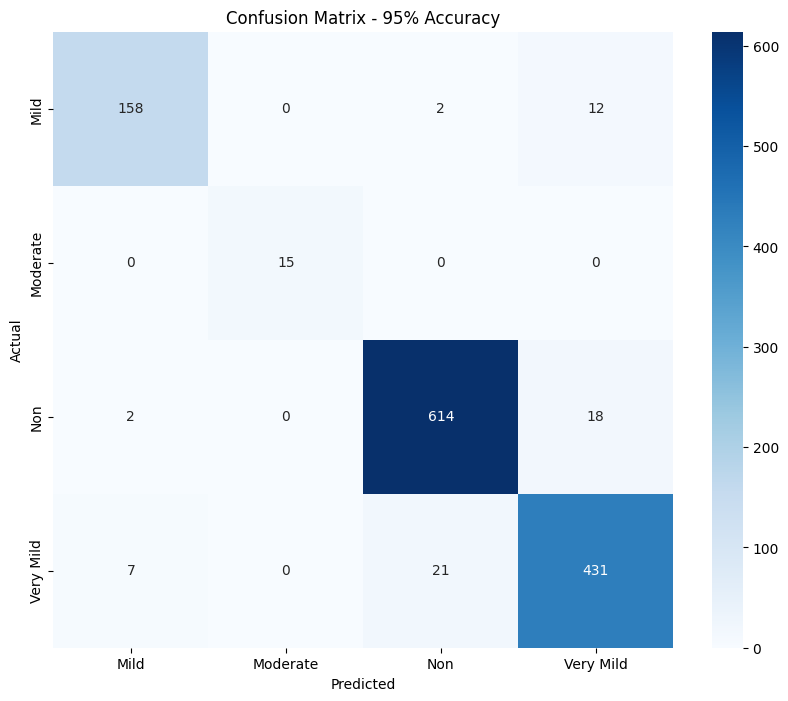

              precision    recall  f1-score   support

        Mild       0.95      0.92      0.93       172
    Moderate       1.00      1.00      1.00        15
         Non       0.96      0.97      0.97       634
   Very Mild       0.93      0.94      0.94       459

    accuracy                           0.95      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.95      0.95      0.95      1280



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Predict on the test/validation set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Collect true labels from the test_generator
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(labels)
y_true = np.array(y_true)

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot it beautifully
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mild', 'Moderate', 'Non', 'Very Mild'],
            yticklabels=['Mild', 'Moderate', 'Non', 'Very Mild'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - 95% Accuracy')
plt.show()

# 4. Print Classification Report (Precision/Recall)
print(classification_report(y_true, y_pred, target_names=['Mild', 'Moderate', 'Non', 'Very Mild']))